# White mask - HSV colorspace pre-process for OCR

This notebook focuses on pre-processing images that contain a single code block using methods that dont rely on the code block's color in order to  produce text using Tesseract OCR.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
import pytesseract
import os
from PIL import Image
from scipy.ndimage import label
from scipy.ndimage import binary_closing

temp_directory = '/home/vasilisp/Desktop/tangibles-recognition/temp/'
A = np.array(Image.open('test_images/new.jpg'))
A = cv.resize(A, dsize=(800, 600), interpolation=cv.INTER_CUBIC)


## White mask

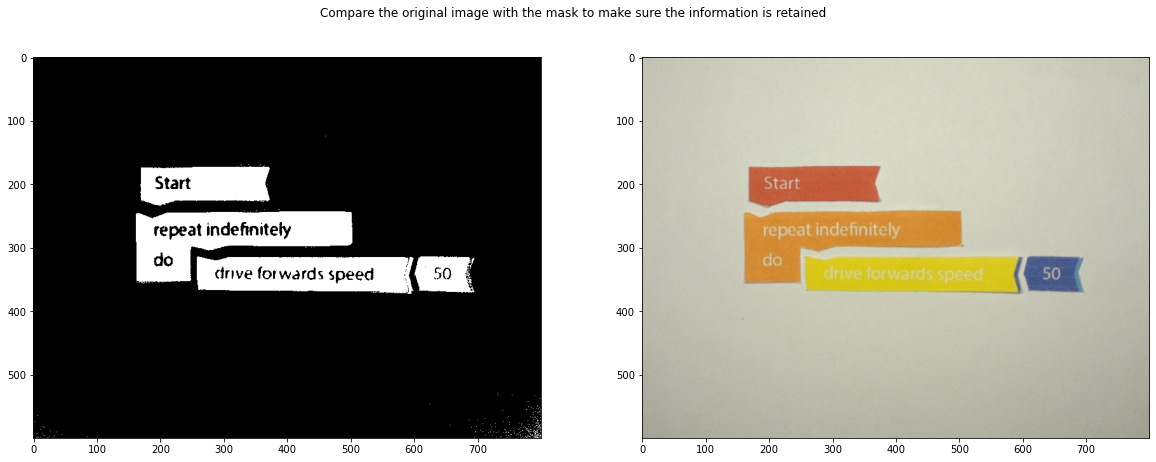

In [2]:
# Finding an hsv value that works well for all blocks:
#
# I picked hsv(42deg, 35%, 74%) that translates to opencv_hsv(21, 90, 189)
# and after a few tests i came up with the following values.

hsv_upper = np.array([180, 140, 225])
hsv_lower = np.array([0, 0, 160])

hsv_A = cv.cvtColor(A, cv.COLOR_RGB2HSV) # where A is the original image
mask = np.invert(cv.inRange(hsv_A, hsv_lower, hsv_upper))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
fig.suptitle('Compare the original image with the mask to make sure the information \
is retained')
ax1.imshow(mask, cmap='gray')
ax2.imshow(A)
fig.show() 

# Result: all the part of the image that we consieder white are affected by the mask
# so the picked hsv space works well.
#
# This didn't work out in the end. Some pixels inside the letters ended up outside
# of the mask and if i changed the [lower, upper] interval other pixels that didn't belong
# to the letters were picked up. I also tried fixing the 'holes' in the letters in the first 
# case with morphological transformations with no reliable results from Tesseract.

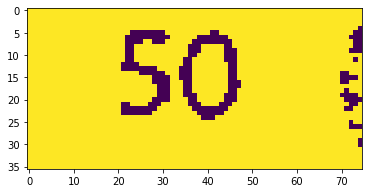

In [8]:
feature_test = np.array(Image.open(temp_directory+'figure_3.jpg'))
test_hsv = cv.cvtColor(feature_test, cv.COLOR_RGB2HSV) 
mask = np.invert(cv.inRange(test_hsv, hsv_lower, hsv_upper))
canny = cv.Canny(mask, 0, 0)
pts = np.argwhere(canny>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)
cropped = mask[y1+10:y2-10, x1+10:x2-10]
plt.imshow(cropped, cmap='gray')
plt.show()

## HSV colorspace

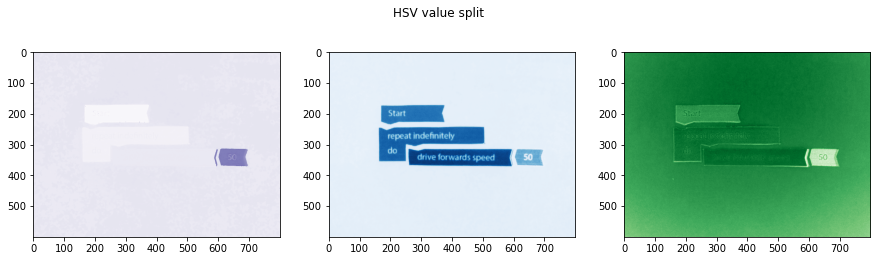

In [4]:
# So as an alternative to the color masking - white mask i will use the saturation chanel of 
# the hsv colorspace to create similar masks as in color masking without relying on color.

h,s,v = cv.split(hsv_A)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('HSV value split')
ax1.imshow(h, cmap='Purples')
ax2.imshow(s, cmap='Blues')
ax3.imshow(v, cmap='Greens')
fig.show() 

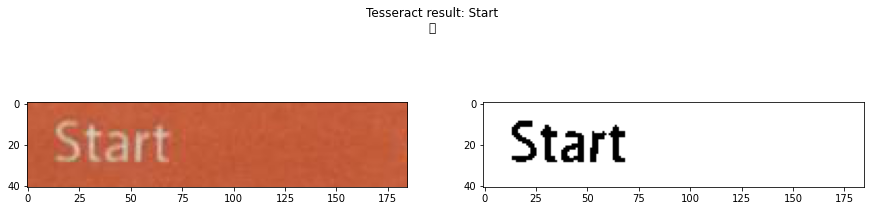

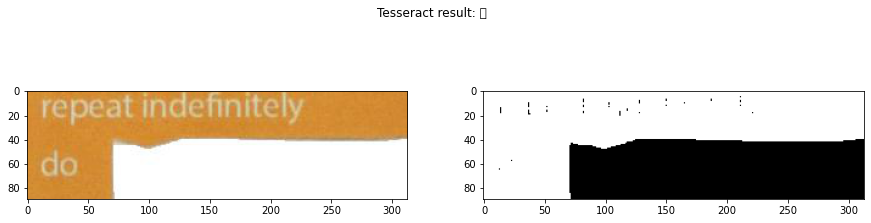

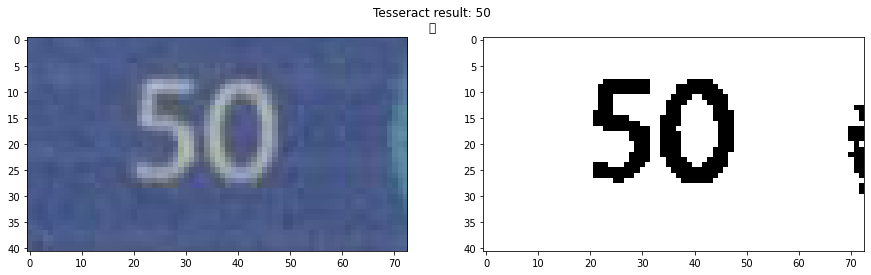

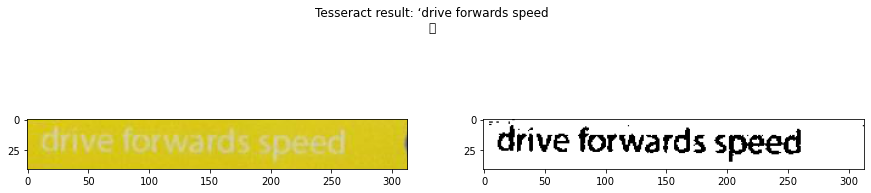

In [5]:
# Using the saturation chanel.

for i in range(1, 5):
    feature = np.array(Image.open(temp_directory+'figure_'+str(i)+'.jpg'))
    hsv_feature = cv.cvtColor(feature, cv.COLOR_RGB2HSV)

    h,s,v = cv.split(hsv_feature)

    # crop base on canny edge detection
    canny = cv.Canny(s, 0, 0)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped = feature[y1+20:y2-20, x1+20:x2-20]
    gray_feature = cv.cvtColor(cropped, cv.COLOR_RGB2GRAY)
    ret3,th_feature = cv.threshold(gray_feature,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    th_feature = np.invert(th_feature)
    text_in_block = pytesseract.image_to_string(th_feature, lang='eng')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle('Tesseract result: '+ text_in_block)
    ax1.imshow(cropped)
    ax2.imshow(th_feature, cmap='gray')
    fig.show() 
    

### Problem 

In the 'repeat indefinitely do' block there is a large white part of the image that
prevents otsu's binarization from working as well as it does on the other blocks. 

Due to the above Tesseract also fails to produce results.